## Excess Frag Calc
Let us consider the case of indistinguishable resources, two examples being (copper/tin) and (fire/nature/ice fragments), which are collected uniformly and statistically independently. The total number of excess resource after pairing in the two-item case is a half normal distribution (negative excess does not exist), and for three is the convolution of 2 two-item distributions resulting in:
$$F(z;n) = 2A\sqrt{\frac{2}{\pi^3n}}\exp{(\frac{-z^2}{12n})}\mathrm{erf}(\frac{z}{2\sqrt{n}})$$

Here there is an adjustment to the normalization $A$ that is associated with the use of a Normal distribution in place of a binomial.
Numerically this comes out to about:
$$A \sim 0.9618$$

See https://math.stackexchange.com/questions/2637182/how-does-one-compute-the-convolution-of-two-half-normal-distributions

In [1]:
import numpy as np
import matplotlib.pyplot
from scipy.special import erf
from scipy.integrate import quad
import numba
plt.style.use("seaborn-dark-palette")
plt.rcParams["figure.figsize"] = (10, 8)

In [2]:
# Comparison of the simulated and analytic forms
@numba.jit
def convert(a, b, c, d=2, s=0):
    L = len(a)
    count = 0
    for z in range(L):
        i, j, k = a[z], b[z], c[z]
        #print("->",i, j, k)
        high = max(i, j, k)
        base = min(i, j, k)
        if high > base + d + 1 + s:
            # convert high to low
            if i == high:
                a = a - d
            elif j == high:
                b = b - d
            else:
                c = c - d
            # Low boost
            if i == base:
                a = a + 1
            elif j == base:
                b = b + 1
            else:
                c = c + 1
        if base > 0:
            count += base
            a = a - base
            b = b - base
            c = c - base
    return count
        
def rstate(k):
    a = np.random.poisson(k)
    b = np.random.poisson(k)
    c = np.random.poisson(k)
    base = min([a,b,c])
    excess = a + b + c - 3*base
    return excess

@numba.jit
def rstateBase(k):
    a = np.cumsum(np.random.poisson(1, k))
    b = np.cumsum(np.random.poisson(1, k))
    c = np.cumsum(np.random.poisson(1, k))
    #base = min([a,b,c])
    #excess = a + b + c - 3*base
    return a, b, c

def rstateTwo(k):
    a = np.random.poisson(k)
    b = np.random.poisson(k)
    base = min([a,b])
    excess = a + b - 2*base
    return excess

Q = lambda z, n: 0.9618*2*(2/np.pi**3/n)**0.5*np.exp(-0.5*z**2/(6*n))*( erf(z/(4*n)**0.5) )
meanExcess = lambda k: quad(lambda x: x*Q(x,k),0,np.inf)[0]

## If conversion existed, would we use it?
The ONLY scale invariant conversion is 1 to 1 (other resource input would be okay of course)
Any other conversion, even 2 to 1, will have a variable stable point depending on the total
expected outcome, and in the infinite regime tends to infinity itself. As a test point, imagine
the conversion to form 100 keys in the 3 frag case, you would ask the question: When is it better
to save duplicates for a later key or convert now in order to best optimize resources. Basically
you would need to decide ahead of time what an upper bound on the number of keys you would ever
do would be, and then that would decide the most efficient time to convert.

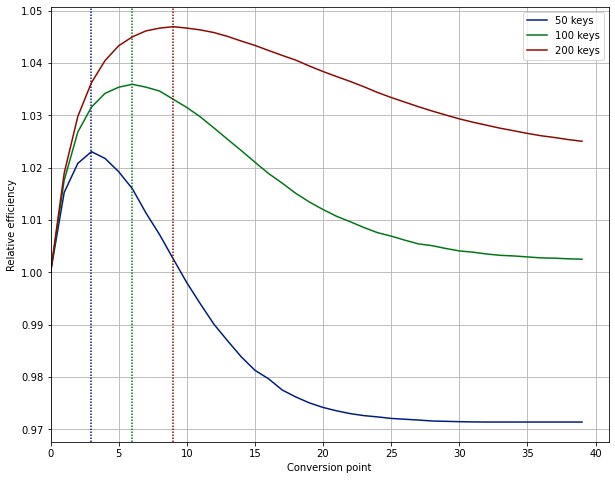

In [3]:
xscale = np.arange(0,40,1)
samples = 1000
@numba.jit
def stalltest(a=100,r=2):
    b = rstateBase(a)
    mset = [convert(*b, r, l) for l in xscale]
    return mset

fifty = np.mean( np.array([stalltest(50, 2) for k in range(samples)]), axis=0 )
fifty = fifty/fifty[0]
hundred = np.mean( np.array([stalltest(100, 2) for k in range(samples)]), axis=0 )
hundred = hundred / hundred[0]
fivehundred = np.mean( np.array([stalltest(200, 2) for k in range(samples)]), axis=0 )
fivehundred = fivehundred/fivehundred[0]
p = plt.plot(xscale, fifty, label="50 keys")
plt.axvline(xscale[ fifty == max(fifty) ][0], color=p[0].get_color(), dashes=[1,1])
p = plt.plot(xscale, hundred, label="100 keys")
plt.axvline(xscale[ hundred == max(hundred) ][0], color=p[0].get_color(), dashes=[1,1])
p = plt.plot(xscale, fivehundred, label="200 keys")
plt.axvline(xscale[ fivehundred == max(fivehundred) ][0], color=p[0].get_color(), dashes=[1,1])
#plt.axhline(j[0], color='black')
plt.xlabel("Conversion point")
plt.ylabel("Relative efficiency")
plt.xlim(left=0)
plt.legend()
plt.grid()
plt.show()

# Without conversion
Without any conversion recipe, the number of excess frags will tend (slowly) towards infinity -- the outcome is that 1 of the 3 will outnumber the others (chosen at random), assuming equal probability.

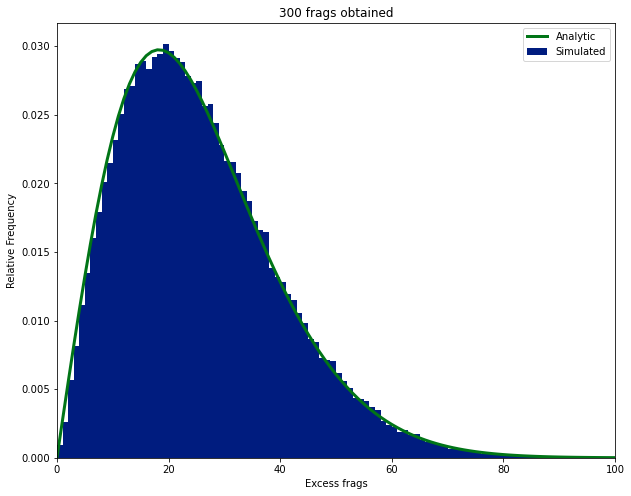

In [4]:
count = 100
p = [rstate(count) for a in range(100000)]
x = np.linspace(0, 100, 101)
plt.hist(p, bins=x, density=True, label="Simulated")

Q = lambda z, n: 0.9618*(2/np.pi**3/n)**0.5*np.exp(-0.5*z**2/(6*n))*( 2*erf(z/(4*n)**0.5) )
Z = Q(x, count)
plt.plot(x, Z, label="Analytic", linewidth=3)

excessMean = np.sum(x*Z)
completeRuns = (count*3-excessMean)/3
fragPerKeep = count*3/completeRuns
print(f'Collecting {count*3} frags gives {excessMean:0.1f} extra for {completeRuns:0.1f} keeps ({fragPerKeep:0.2f} frags each)')

plt.xlabel("Excess frags")
plt.ylabel("Relative Frequency")
plt.title("300 frags obtained")
plt.xlim(x.min(), x.max())
plt.legend()
plt.show()

To further demonstrate this, note that as the total number of drops increases, so does the excess.

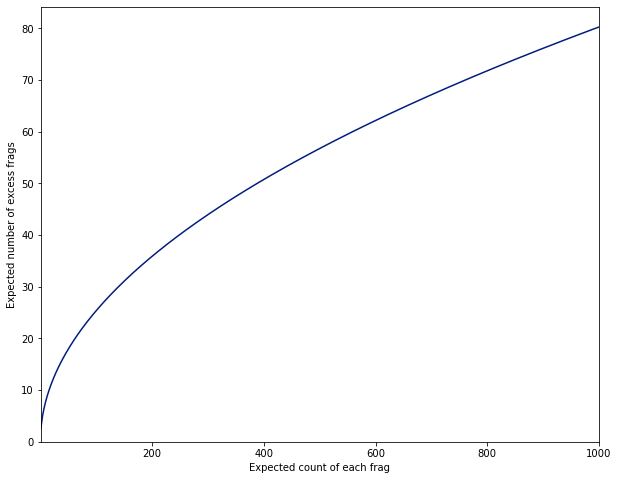

In [5]:
frags = np.linspace(1, 1000, 1000)
xfrags = np.array([meanExcess(a) for a in frags])
plt.plot(frags, xfrags)
plt.xlabel("Expected count of each frag")
plt.ylabel("Expected number of excess frags")
plt.ylim(bottom=0)
plt.xlim(frags.min(), frags.max())
plt.show()

This might seem at odds with the central limit theorem (law of averages); however, that is not the case. The expected number of collected frags per keep does tend towards 3 (from above) as the total number of frags tends to infinity, this is because the excess grows more slowly than the total. Note below how as the total number of keeps increases, the number of keeps per 3 frags tends towards 1 -- this is the central limit theorem / law of averages everyone expects.

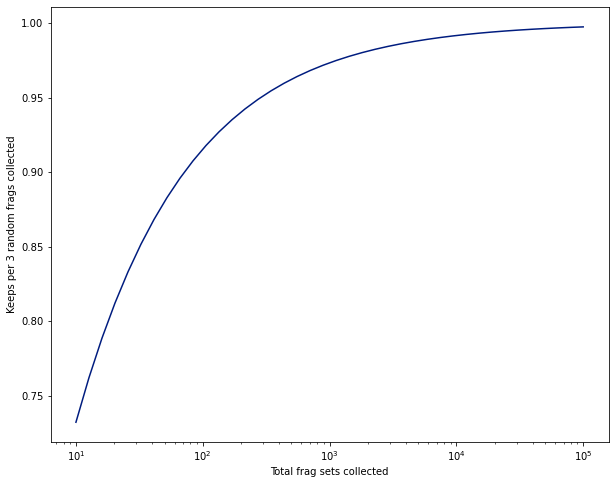

In [6]:
frags = np.logspace(1, 5, 40)
xfrags = np.array([meanExcess(a) for a in frags])
keepsPerFrag = (frags*3 - xfrags)/3/frags
plt.plot(frags, keepsPerFrag)
plt.ylabel("Keeps per 3 random frags collected")
plt.xlabel("Total frag sets collected")
plt.xscale("log")
plt.show()

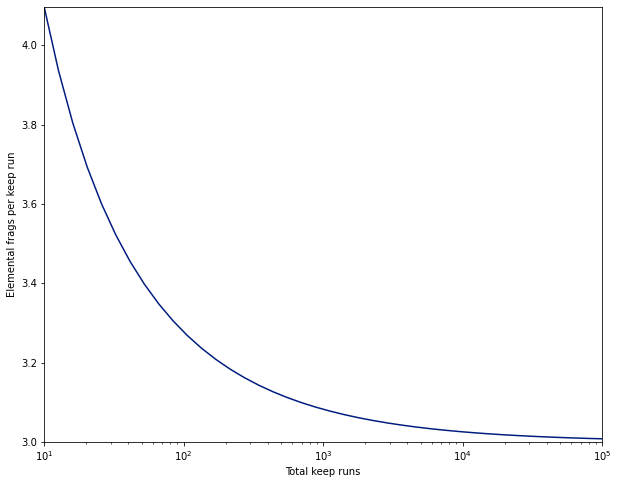

In [7]:
# Maybe slightly more intuitive, number of elemental frags per keep
plt.plot(frags, 3/keepsPerFrag)
plt.xscale("log")
plt.ylabel("Elemental frags per keep run")
plt.xlabel("Total keep runs")
plt.xlim(10,1e5)
plt.ylim(3,(3/keepsPerFrag).max())
plt.show()